In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_analysis_config import col_name_map, TYPES_COLUMN_NAMES, categorize_by_quantile
from itertools import chain



## **PRE-WORK**
### PREPARE DATA
1. Load data
2. Rename columns
3. Delete non-numeric columns


In [2]:
# load dataframe
key_df = pd.read_csv('../csv_output/merged_key_misspells.csv', sep=';')
fp_df = pd.read_csv('../csv_output/fp.csv', sep=';')
rand_df = pd.read_csv('../csv_output/merged_random_misspells.csv', sep=';')

fp_df['amount_of_errors'] = 0

# rename dataframe
fp_df.rename(columns=col_name_map, inplace=True)
key_df.rename(columns=col_name_map, inplace=True)
rand_df.rename(columns=col_name_map, inplace=True)

fp_df['Function'] = fp_df["Function"].astype("category")
key_df['Function'] = key_df["Function"].astype("category")
rand_df['Function'] = rand_df["Function"].astype("category")

# delete strings
fp_df = fp_df.select_dtypes(exclude=['object'])
key_df = key_df.select_dtypes(exclude=['object'])
rand_df = rand_df.select_dtypes(exclude=['object'])

fp_df['Function'] = fp_df["Function"].astype("object")
key_df['Function'] = key_df["Function"].astype("object")
rand_df['Function'] = rand_df["Function"].astype("object")

In [3]:
columns = ['Damerau–Levenshtein normalized similarity'] + [col for cat in TYPES_COLUMN_NAMES.values() for col in cat] + ['Function', 'Amount of misspells (in input sentence)']
fp_df = fp_df[columns]
key_df = key_df[columns]
rand_df = rand_df[columns]

### Add each sentence to a bucket: 
1. [1, 3) errors
2. [3, 6) errors
3. [6, +inf)

In [4]:
key_df['Bucket'] = key_df['Amount of misspells (in input sentence)'].apply(lambda x: 1 if x < 3 else ( 2 if 3 <= x <= 5 else 3))
rand_df['Bucket'] = key_df['Amount of misspells (in input sentence)'].apply(lambda x: 1 if x < 3 else ( 2 if 3 <= x <= 5 else 3))

In [5]:
key_based_dataframes = [key_df.loc[key_df['Bucket'] == i].reset_index(drop=True) for i in range(1, 4)]
rand_based_dataframe = [rand_df.loc[rand_df['Bucket'] == i].reset_index(drop=True)  for i in range(1, 4)]
del key_df, rand_df


#### Define quantiles and categorize each of metrics (basing on perfect match & quantiles)

In [6]:
config = pd.DataFrame()
CATEGORIES = [1,2,3,4] # WHERE 1 IS TOP and 4 IS BOTTOM


for by in list(chain.from_iterable(TYPES_COLUMN_NAMES.values())):
    # define the quantiles
    quantiles = {"key": [], 'rand': [], 'fp': []}
    for i in range(len(key_based_dataframes)):
        quantiles['key'].append(key_based_dataframes[i][by].quantile([0.25, 0.5, 0.75]).values)
        quantiles['rand'].append(rand_based_dataframe[i][by].quantile([0.25, 0.5, 0.75]).values)
    quantiles['fp'] = (fp_df[by].quantile([0.25, 0.5, 0.75]).values)


    if 'normalized similarity'.lower() in by.lower():
        ascending = True
        goal = 1.0
    else: 
        ascending = False
        goal = 0.0


    for i in range(len(quantiles['key'])):
        config[f'{by} key group {i} bucket'] = np.concatenate((quantiles['key'][i], [goal, ascending]))
        config[f'{by} rand group {i} bucket'] = np.concatenate(
            (quantiles['rand'][i], [goal, ascending])
        )
    # assign to config quantiles, goal and ascending    
    config[f'{by} fp quantiles'] = np.concatenate((quantiles['fp'], [goal, ascending]))

    for k in range(len(key_based_dataframes)):
        key_based_dataframes[k].insert(list(key_based_dataframes[k].columns).index(by), by + " Result category" , key_based_dataframes[k][by].apply(lambda x: categorize_by_quantile(x, goal, quantiles['key'][k], values = CATEGORIES, ascending_is_better=ascending)))
        rand_based_dataframe[k].insert(list(rand_based_dataframe[k].columns).index(by), by + " Result category" , rand_based_dataframe[k][by].apply(lambda x: categorize_by_quantile(x, goal, quantiles['rand'][k], values =  CATEGORIES, ascending_is_better=ascending)))
    fp_df.insert(list(fp_df.columns).index(by), by + " Result category" , fp_df[by].apply(lambda x: categorize_by_quantile(x, goal, quantiles['fp'], values =  CATEGORIES, ascending_is_better=ascending)))


In [7]:
config = config.transpose()


In [8]:
config.columns
names = {0: 'quantile 1', 1: 'quantile 2', 2: 'quantile 3', 3: 'Goal', 4: 'Ascending'}
config.rename(names, inplace=True, axis=1)


#### Define CONSTS

In [9]:
COLUMNS_FOR_RESULT_CATEGORY = [col for col in fp_df.columns if 'Result category' in col]
COLUMN_NAMES_FOR_CATEGORIES = ['Full correctness', 'First range', 'Second range', 'Third range']

#### Filter columns

In [10]:
for k in range(len(key_based_dataframes)):
    key_based_dataframes[k] = key_based_dataframes[k][COLUMNS_FOR_RESULT_CATEGORY + ['Function']]
    rand_based_dataframe[k] = rand_based_dataframe[k][COLUMNS_FOR_RESULT_CATEGORY + ['Function']]
fp_df = fp_df[COLUMNS_FOR_RESULT_CATEGORY + ['Function']]


In [11]:
def get_summary(data_frame, column_names_for_values: list, category_values_to_parse: list, normalized_values: bool = False):
    scores = pd.DataFrame()
    for by in data_frame.columns[:-1]:
        # Compute the cross-tabulation of the 'Function' and the column
        scores = pd.concat([scores, data_frame.groupby('Function')[by].agg(
            [(f'{column_names_for_values[0]} {by}', lambda x: (x == category_values_to_parse[0]).sum()),
             #  ])])
             (f'{column_names_for_values[1]} {by}', lambda x: (x == category_values_to_parse[1]).sum()),
             (f'{column_names_for_values[2]} {by}', lambda x: (x == category_values_to_parse[2]).sum()),
             (f'{column_names_for_values[3]} {by}', lambda x: (x == category_values_to_parse[3]).sum()),

             ])], axis=1)

    scores = pd.concat([scores, data_frame.groupby('Function')[data_frame.columns[0]].agg(
        [('Total count', 'count')])], axis=1)
    if normalized_values:
        for col_name in scores.columns[:-1]:
            scores[col_name] = scores[col_name] / scores['Total count']
    return scores
    

In [12]:
def get_weitghted_average (dataframe, weights, only_average_columns=False):
    for i in COLUMNS_FOR_RESULT_CATEGORY:
        summary_column_names = [k for k in dataframe.columns if i in k]
        dataframe[f'Weighted average {i}'] = dataframe[summary_column_names].dot(weights)
    averages_columns = [k for k in dataframe.columns if "Weighted average" in k]

    if only_average_columns:
        return dataframe[averages_columns], averages_columns
    return dataframe, averages_columns


## **ANALYSIS**

In [13]:
summary = {}
RANGE_WEIGTHS = [1,0,0,0] # weigths for perfect match  & quantiles 
# fp 
summary_df, averages_columns = get_weitghted_average(get_summary(fp_df, column_names_for_values=COLUMN_NAMES_FOR_CATEGORIES, category_values_to_parse=CATEGORIES, normalized_values=True), RANGE_WEIGTHS)
summary_df['Summary'] = summary_df[averages_columns].sum(axis=1)
summary['FP'] = summary_df
for k in range(len(key_based_dataframes)):
    # key based
    summary_df, averages_columns = get_weitghted_average(get_summary(key_based_dataframes[k], column_names_for_values=COLUMN_NAMES_FOR_CATEGORIES, category_values_to_parse=CATEGORIES, normalized_values=True), RANGE_WEIGTHS)
    summary_df['Summary'] = summary_df[averages_columns].sum(axis=1)
    summary[f'key {k+1}'] = summary_df
    # random
    summary_df, averages_columns = get_weitghted_average(get_summary(rand_based_dataframe[k], column_names_for_values=COLUMN_NAMES_FOR_CATEGORIES, category_values_to_parse=CATEGORIES, normalized_values=True), RANGE_WEIGTHS)
    summary_df['Summary'] = summary_df[averages_columns].sum(axis=1)
    summary[f'random {k+1}'] = summary_df
    

In [18]:
# Concatenate the columns from each dataframe into a single dataframe
merged_column_df = pd.concat([df["Summary"] for df in summary.values()], axis=1,keys=summary.keys())

# Set the index of the merged dataframe to the index of one of the source dataframes
index_df = list(summary.values())[0]  # choose one of the source dataframes as index reference
merged_column_df = merged_column_df.set_index(index_df.index)


In [22]:
POINTS = [30, 25, 22, 18, 15, 12] + list(range(1, 10))

total = pd.DataFrame(0, index=merged_column_df.index, columns=merged_column_df.columns)
for col in merged_column_df.columns:
    sorted_df = merged_column_df[col].sort_values(ascending=False)
    for i, tool in enumerate(sorted_df.index[:15]):
        total.loc[tool, col] = POINTS[i]


In [36]:
# ERROR_TYPE_CATEGORY_WEIGTH = [1,1,1,1,1,1,1]
ERROR_TYPE_CATEGORY_WEIGTH = [0.8, 1, 1, 0.8, 0.8, 0.3, 0.3]
total['TOTAL'] = np.dot(merged_column_df, ERROR_TYPE_CATEGORY_WEIGTH)
total.sort_values(by='TOTAL', inplace=True, ascending=False)


In [48]:
consts = {
"POINTS FOR TOP N": tuple(POINTS) , 
"ERROR_TYPE_CATEGORY_WEIGTH (FP, [KEY(n), RAND(n)] for n in range(3))": tuple(ERROR_TYPE_CATEGORY_WEIGTH), 
"PERFECT MATCH, 1-4 QUANTILES RESUULT WEIGHT": tuple(RANGE_WEIGTHS)
}
consts = pd.DataFrame.from_dict(consts, orient='index').transpose()

,POINTS FOR TOP N,"ERROR_TYPE_CATEGORY_WEIGTH (FP, [KEY(n), RAND(n)] for n in range(3))","PERFECT MATCH, 1-4 QUANTILES RESUULT WEIGHT"
0,30.0,0.8,1.0
1,25.0,1.0,0.0
2,22.0,1.0,0.0
3,18.0,0.8,0.0
4,15.0,0.8,NaN
5,12.0,0.3,NaN
6,1.0,0.3,NaN
7,2.0,NaN,NaN
8,3.0,NaN,NaN
9,4.0,NaN,NaN


dict_keys(['FP', 'key 1', 'random 1', 'key 2', 'random 2', 'key 3', 'random 3'])

In [54]:
with pd.ExcelWriter('multiple_sheets.xlsx') as writer:
    consts.to_excel(writer, sheet_name='consts_config', index=False)
    config.to_excel(writer, sheet_name='config', index=True)
    for k in summary.keys():
        summary[k].to_excel(writer, sheet_name=f'{k}', index=True)
    merged_column_df.to_excel(writer, sheet_name='merged columns', index=True)
    total.to_excel(writer, sheet_name='total', index=True)

IndexError: index 3 is out of bounds for axis 0 with size 3

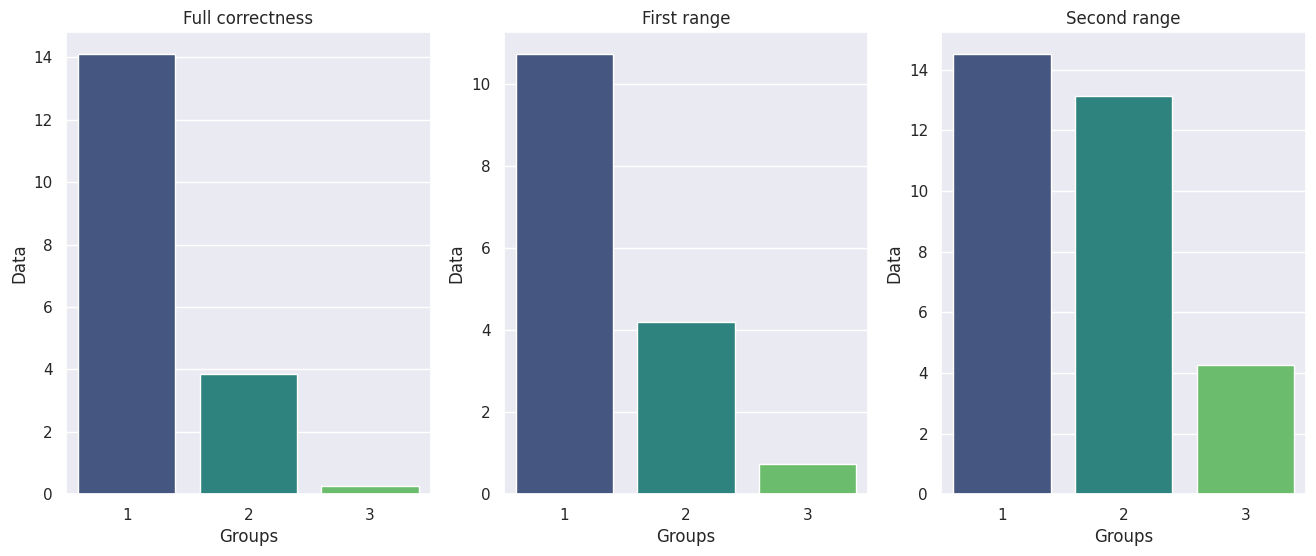

In [34]:
sns.set(rc={'figure.figsize':(16,6)})
fig, axs = plt.subplots(ncols=3)
grouped_df = scores.groupby('bucket')
for i, col in enumerate(grouped_df.columns):
    sns.barplot(data=grouped_df, x=grouped_df.index, y=col, ax=axs[i], palette='viridis')
    axs[i].set_xlabel('Groups')
    axs[i].set_ylabel('Data')
    axs[i].set_title(col)


# scores[['Full correctness',	'First range',	'Second range']].plot(kind='bar', stacked = True)
# plt.set_xlabel('Function')
# plt.bar(scores.index, scores['Full correctness'], label='Full correctness')
# plt.bar(scores.index, scores['Full correctness'], bottom=scores['First range'], label='Second range')

sns.barplot(data=scores, x=scores.index, y=COLUMN_NAMES_FOR_CATEGORIES[0], color='blue', label=by)
sns.barplot(data=scores, x=scores.index, y=COLUMN_NAMES_FOR_CATEGORIES[1], color='green', bottom=scores[COLUMN_NAMES_FOR_CATEGORIES[0]], label=by)
sns.barplot(data=scores, x=scores.index, y=COLUMN_NAMES_FOR_CATEGORIES[2], color='red', bottom=scores[COLUMN_NAMES_FOR_CATEGORIES[0]] + scores[COLUMN_NAMES_FOR_CATEGORIES[1]], label=by)

# Set labels and legend
plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 7
plt.xlabel('Groups')
plt.ylabel('Data')
plt.title('Stacked Bar Plot')
plt.legend()

# Show plot
plt.show()


# plt.bar =

### potrojny 